# Example: Penguins Dataset

In [1]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

sns.set_style('white')

There exist multiple penguin species throughout Antarctica, including the Adelie, Chinstrap, and Gentoo. When encountering one of these penguins on an Antarctic trip, we might classify its species

$$
Y= \begin{cases}A & \text { Adelie } \\ C & \text { Chinstrap } \\ G & \text { Gentoo }\end{cases}
$$

by examining various physical characteristics, such as whether the penguin weighs more than the average $4200 \mathrm{~g}$,

$$
X_1= \begin{cases}1 & \text { above-average weight } \\ 0 & \text { below-average weight }\end{cases}
$$

as well as measurements of the penguin's bill

$$
\begin{aligned}
& X_2=\text { bill length }(\text { in } \mathrm{mm}) \\
& X_3=\text { flipper length }(\text { in } \mathrm{mm})
\end{aligned}
$$

The penguins_bayes data, originally made available by Gorman, Williams, and Fraser (2014) and distributed by Horst, Hill, and Gorman (2020), contains the above species and feature information for a sample of 344 Antarctic penguins:

In [2]:
penguins = sns.load_dataset('penguins')

In [3]:
# display(penguins.head())

penguins.head().style.set_table_attributes('style="font-size: 13px"')

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.100000,18.700000,181.000000,3750.000000,Male
1,Adelie,Torgersen,39.500000,17.400000,186.000000,3800.000000,Female
2,Adelie,Torgersen,40.300000,18.000000,195.000000,3250.000000,Female
3,Adelie,Torgersen,nan,nan,nan,nan,nan
4,Adelie,Torgersen,36.700000,19.300000,193.000000,3450.000000,Female


In [4]:
display(penguins.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


None

In [5]:
display(penguins.describe())

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


Among these penguins, 152 are Adelies, 68 are Chinstraps, and 124 are Gentoos. We’ll assume throughout that the proportional breakdown of these species in our dataset reflects the species breakdown in the wild. That is, our prior assumption about any new penguin is that it’s most likely an Adelie and least likely a Chinstrap:

In [6]:
display(penguins['species'].value_counts(normalize=False))
display(penguins['species'].value_counts(normalize=True))

Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64

Adelie       0.441860
Gentoo       0.360465
Chinstrap    0.197674
Name: species, dtype: float64

We drop `sex` column for simplicity as there are quite a few missing values in it.

In [7]:
penguins = penguins.drop(columns=["sex"], inplace=False).reset_index(drop=True)

We also drop the other NA rows, there are only 2 of them.

In [8]:
penguins = penguins.dropna().reset_index(drop=True) # drop rows with NAs, only 2 rows
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0
...,...,...,...,...,...,...
337,Gentoo,Biscoe,47.2,13.7,214.0,4925.0
338,Gentoo,Biscoe,46.8,14.3,215.0,4850.0
339,Gentoo,Biscoe,50.4,15.7,222.0,5750.0
340,Gentoo,Biscoe,45.2,14.8,212.0,5200.0


In [9]:
display(penguins['species'].value_counts(normalize=False))
display(penguins['species'].value_counts(normalize=True))

Adelie       151
Gentoo       123
Chinstrap     68
Name: species, dtype: int64

Adelie       0.441520
Gentoo       0.359649
Chinstrap    0.198830
Name: species, dtype: float64

In [10]:
print(f"The mean body mass of penguins is {penguins['body_mass_g'].mean():.2f} grams.")

The mean body mass of penguins is 4201.75 grams.


We create a new categorical feature `overweight` which is 1 if the `body_mass_g` is over the 
mean, and 0 otherwise. This feature corresponds to our earlier defined random variable $X_1$.

In [11]:
penguins["overweight"] = (penguins["body_mass_g"] > penguins["body_mass_g"].mean()).astype(int)
display(penguins["overweight"].value_counts())

0    193
1    149
Name: overweight, dtype: int64

## The Prior

The prior distribution for $Y$ is a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) with three categories, one for each species. The prior probabilities are given by the relative frequencies of each species in the dataset:

$$
\begin{aligned}
& \text { A } \sim \text { Categorical }(\pi_A=0.44) \\
& \text { C } \sim \text { Categorical }(\pi_C=0.20) \\
& \text { G } \sim \text { Categorical }(\pi_G=0.36)
\end{aligned}
$$

which implies

$$
\begin{aligned}
\mathbb{P}(Y=A) &= 0.44 \\
\mathbb{P}(Y=C) &= 0.20 \\
\mathbb{P}(Y=G) &= 0.36
\end{aligned}
$$

Given a new penguin not in the dataset, the **prior assumption** says that the probability 
of it being an Adelie is $0.44$, the probability of it being a Chinstrap is $0.20$, and the probability of it being a Gentoo is $0.36$. 

Reference: [The Bayes Rules Book](https://www.bayesrulesbook.com/chapter-2.html#building-a-bayesian-model-for-events).

## Classifying one penguin

Consider a new penguin with the following features:

- `body_mass_g` $< 4200 \mathrm{~g}$ (`overweight` = 0 if `body_mass_g` $< 4200 \mathrm{~g}$, 1 otherwise)
- `bill_length_mm` $50 \mathrm{~mm}$
- `flipper_length_mm` $195 \mathrm{~mm}$

Then we want to find out the posterior distribution of the species of this penguin, given the features. 
In other words, what is the probability of this penguin being an Adelie, Chinstrap, or Gentoo, given the features?

### One Categorical Feature

Let's start with the first feature, `body_mass_g` and since the penguin weights less than the average weight of $4200 \mathrm{~g}$, it belongs to the category $0$ of the feature `overweight`.

In [12]:
total = penguins.groupby("species").size().reset_index(name="counts")
display(total)

overweight = (
    penguins[penguins["overweight"] == 1]
    .groupby("species")["overweight"]
    .sum()
    .reset_index()
)
display(overweight)

overweight["overweight"] = [
    i / j * 100 for i, j in zip(overweight["overweight"], total["counts"])
]
total["counts"] = [i / j * 100 for i, j in zip(total["counts"], total["counts"])]

display(total)
display(overweight)  # percentage of overweight penguins for each species

,species,counts
0,Adelie,151
1,Chinstrap,68
2,Gentoo,123


,species,overweight
0,Adelie,25
1,Chinstrap,7
2,Gentoo,117


,species,counts
0,Adelie,100.0
1,Chinstrap,100.0
2,Gentoo,100.0


,species,overweight
0,Adelie,16.556291
1,Chinstrap,10.294118
2,Gentoo,95.121951


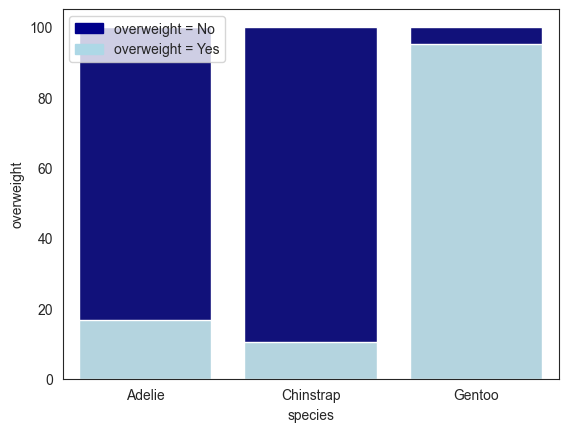

In [13]:
# bar chart 1 -> top bars (group of 'overweight=No')
bar1 = sns.barplot(x="species", y="counts", data=total, color="darkblue")

# bar chart 2 -> bottom bars (group of 'overweight=Yes')
bar2 = sns.barplot(x="species", y="overweight", data=overweight, color="lightblue")

# add legend
top_bar = mpatches.Patch(color="darkblue", label="overweight = No")
bottom_bar = mpatches.Patch(color="lightblue", label="overweight = Yes")
plt.legend(handles=[top_bar, bottom_bar])

# show the graph
plt.show()

Before we do anything, we are given one categorical variable and for this penguin, it falls under
category $0$ of the `overweight` feature (i.e. underweight).

From the conditionals below, the Chinstrap species have the highest probability of underweight penguins by
the relative freqeuncy table. That is, for each species, we compute the relative frequency within each species as 

$$
\begin{aligned}
\mathbb{P}[X_1=0|Y=A] &= 0.8344 \\
\mathbb{P}[X_1=0|Y=C] &= 0.8971 \\
\mathbb{P}[X_1=0|Y=G] &= 0.0488 \\
\end{aligned}
$$

Note that we are abusing the notation $\mathbb{P}$ here, since we are not talking about the probability of a random variable, but rather the relative frequency of a feature within a species.
Also note the above expressions is the conditional probability of $X_1=0$ given $Y$ is a certain species, also termed as the **likelihood** of $Y$ being a certain species given $X_1=0$. Again, we are being loose with notation here as everything here is empirical!

So one might say that the Chinstrap species is the least likely to be overweight, and the Gentoo species is the most likely to be overweight. Well, this makes intuitive sense since we are talking
about "likelihood" here: of all $P(X_1=0|Y=A)$, $P(X_0=1|Y=C)$, and $P(X_1=0|Y=G)$, the Chinstrap species is the least likely to be overweight.

Yet before we can make any conclusions, we need to take into account the prior probabilities of each species. We should weight the relative frequencies by the prior probabilities of each species. Intuitively, since Chinstrap is also the ***rarest*** species, it diminishes the likelihood of the penguin being a Chinstrap.

We need to use both the prior and the likelihood to compute the posterior distribution of the species of the penguin. 
The posterior distribution is the probability of the species of the penguin given the features.

$$
\begin{aligned}
\mathbb{P}[Y=y|X_1=x_1] = \frac{\mathbb{P}[X_1=x_1|Y=y] \mathbb{P}[Y=y]}{\mathbb{P}[X_1=x_1]}
\end{aligned}
$$

For example, if our given feature of the test penguin is $X_1=0$, then we need
to find the posterior distribution of **all** species given $X_1=0$. That is, we need to compute

$$
\begin{aligned}
\mathbb{P}[Y=A|X_1=0] &= \frac{\mathbb{P}[X_1=0|Y=A] \mathbb{P}[Y=A]}{\mathbb{P}[X_1=0]} \\
\mathbb{P}[Y=C|X_1=0] &= \frac{\mathbb{P}[X_1=0|Y=C] \mathbb{P}[Y=C]}{\mathbb{P}[X_1=0]} \\
\mathbb{P}[Y=G|X_1=0] &= \frac{\mathbb{P}[X_1=0|Y=G] \mathbb{P}[Y=G]}{\mathbb{P}[X_1=0]}
\end{aligned}
$$

and get the **argmax** of the above three expressions. The argmax is the species with the highest probability.
Note this makes sense because $\mathbb{P}[Y=y|X_1=x_1]$ is a legitimate probability measure, since it sums to $1$.

The **argmax** expression is as follows:

$$
\begin{aligned}
\text{argmax}_{y \in \{A, C, G\}} \mathbb{P}[Y=y|X_1=0] &= \text{argmax}_{y \in \{A, C, G\}} \frac{\mathbb{P}[X_1=0|Y=y] \mathbb{P}[Y=y]}{\mathbb{P}[X_1=0]} \\
&= \text{argmax}_{y \in \{A, C, G\}} \frac{\mathbb{P}[X_1=0|Y=y] \mathbb{P}[Y=y]}{\sum_{y' \in \{A, C, G\}} \mathbb{P}[X_1=0|Y=y'] \mathbb{P}[Y=y']}
\end{aligned}
$$

Note in the Bayes Rules Book, the authors used the notation $f$ instead of $\mathbb{P}$, 
they are the same thing in this context since both $X_1$ and $Y$ are discrete random variables.
Consequently, the right hand side of the equation $\mathbb{P}[X_1=x_1|Y=y]$ is 
gives us a concrete value. However, if $X_1$ were a continuous random variable, as we will see in the
next section, then the expression $\mathbb{P}[X_1=x_1|Y=y]$ would not make much sense since
we the conditional probability of a continuous random variable at a point $x_1$ is $0$ by definition.

We reconcile this by expressing Bayes Rule in terms of the probability density function (PDF) of the posterior distribution.

The conditional PDF of the posterior distribution is

$$
\begin{aligned}
f_{Y|X_1}(y|x_1) = \frac{f_{X_1|Y}(x_1|y) f_{Y}(y)}{f_{X_1}(x_1)}
\end{aligned}
$$

We make a bold statement now (not proven but will do so) that the $\hat{y}$ that maximizes
the posterior distribution in terms of Bayes Rules is the same as the $\hat{y}$ that maximizes
the posterior distribution in terms of the conditional PDF. 

If this statement is true, then 

$$
\begin{aligned}
\text{argmax}_{y \in \{A, C, G\}} f_{Y|X_1}(y|x_1) &= \text{argmax}_{y \in \{A, C, G\}} \frac{f_{X_1|Y}(x_1|y) f_{Y}(y)}{f_{X_1}(x_1)} \\
&= \text{argmax}_{y \in \{A, C, G\}} \frac{f_{X_1|Y}(x_1|y) f_{Y}(y)}{\sum_{y' \in \{A, C, G\}} f_{X_1|Y}(x_1|y') f_{Y}(y')}
\end{aligned}
$$

We pause here and move on to the discrete case, but in any case, we can also use
the conditional PMF here, where the author sort of abused the notation here by using $f$ instead of $\mathbb{P}$.


The table below breaks down the joint distribution table of $Y$ and $X_1$, since
both are categorical, it is easy to compute the joint distribution table.

| $Y$ | $X_1 = 0$ | $X_1 = 1$ | $\sum$ |
| --- | --- | --- | --- |
| A | 126 | 25 | 151 |
| C | 61 | 7 | 68 |
| G | 6 | 117 | 123 |
| $\sum$ | 193 | 149 | 342 |


| $Y$ | $X_1 = 0$ | $X_1 = 1$ | $\sum$ |
| --- | --- | --- | --- |
| A | 0.365 | 0.072 | 0.437 |
| C | 0.178 | 0.020 | 0.198 |
| G | 0.017 | 0.342 | 0.359 |
| $\sum$ | 0.560 | 0.434 | 1.000 |



The image is a sketch of the joint distribution table of $Y$ and $X_1$.

```{figure} ../assets/penguin_overweight_joint_sketch.jpg
---
height: 400px
name: penguin-overweight-joint
---
Joint distribution diagram of $Y$ and $X_1$.
```

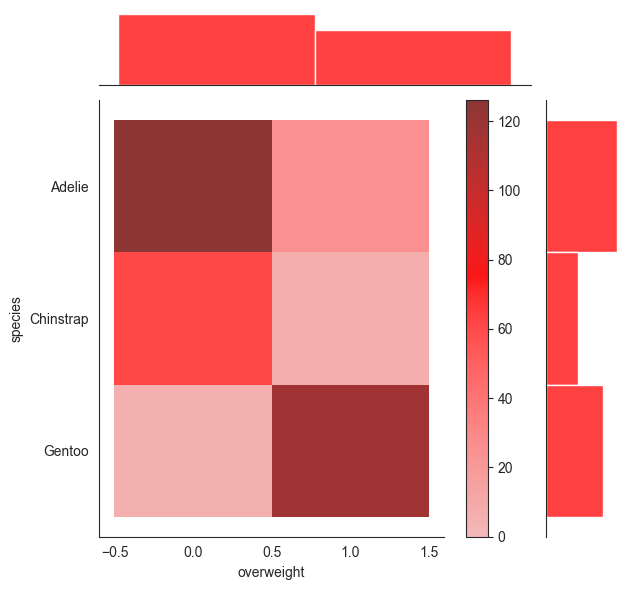

In [14]:
g = sns.JointGrid(data=penguins, x="overweight", y="species")
low, high = 0, 1
# bins =  np.arange(0, high + 1.5) - 0.5 # [-0.5, 0.5, 1.5]
g.plot_joint(sns.histplot,discrete=True, cbar=True, color="red")
g.plot_marginals(sns.histplot, discrete=True, color="red");

We can also use seaborns `jointgrid` to do a joint distribution plot, the darker tone of red
corresponds to a higher impulse of the joint distribution.

Indeed we can see that Adelie + overweight = 0 and Gentoo + overweight = 1 are the
most red tone, indicating that $\mathbb{P}[X_1=0, Y=A]$ and $\mathbb{P}[X_1=1, Y=G]$ are the highest
impulses of the joint distribution.

In our table they correspond to 0.365 and 0.342 respectively.

The top and right are the marginal distribution of $Y$ and $X_1$ respectively. They are
just relative frequencies.

Note the above all uses histo plot as default, where we used normal histograms to
"estimate" the PDF of the joint distribution. We can also use a kernel density estimation (KDE) to
do so, which is a bit more smooth and accurate. Note everything here is JUST an estimation. We will
use it in continuous distributions later.

To see the empirical conditional distribution of $X_1=0$ given $Y=C$ for example,
it is simply given by the table above. To calculate we ask ourselves the following question:

what is $P(X_1=0|Y=C)$? We simply look at the table EARLIER and see that it is $0.8971$. But to 
read it off this joint distribution table, you first need to recognize that when $Y=C$, we have shrinked our table to only the rows where $Y=C$ (2nd row). Then we look at the column where $X_1=0$ and see that it is 61, then we divide by the sum of the row, which is 68, to get $0.8971$.

In this scenario, the author mentioned that we can actually directly compute the posterior probability from the empirical joint distribution table.

For example, if we want to calculate the posterior probability of $Y=A$ given $X_1=0$, 
we simply look at the column $X_1=0$ and calculate the relative frequency of $Y=A$,

$$
\mathbb{P}[Y=A|X_1=0] = \frac{126}{193} = 0.652
$$

or equivalently

$$
\mathbb{P}[Y=A|X_1=0] = \frac{0.365}{0.560} = 0.652
$$

Note that we are still talking about empirical here, so nothing is really proven yet.

In a similar fashion, we have

$$
\mathbb{P}[Y=C|X_1=0] = \frac{61}{193} = 0.315
$$


$$
\mathbb{P}[Y=G|X_1=0] = \frac{6}{193} = 0.031
$$


We can confirm this by computing the posterior distribution using the formula above.

Firstly, our prior says that

$$
\begin{aligned}
\mathbb{P}[Y=A] &= \frac{151}{342} = 0.4415 \\
\mathbb{P}[Y=C] &= \frac{68}{342} = 0.1988 \\
\mathbb{P}[Y=G] &= \frac{123}{342} = 0.3596 \\
\end{aligned}
$$

These values will handle the $\mathbb{P}[Y=y]$ term in the formula above.
I have to emphasize again that all of these are empirical probabilities, the actual
probability of the species of the penguin is not known, i.e $\mathbb{P}[Y=y]$ is not known
but we can reasonably estimate it using statistics, and in this case we estimate
it using the relative frequency of each species, we will see later that the
relative frequency is a good estimator of the actual probability by Maximum Likelihood Estimation.

Next, we find the likelihood terms of $\mathbb{P}[X_1=0|Y=y]$ for each species $y$. 

$$
\begin{aligned}
\mathbb{P}[X_1=0|Y=A] &= \frac{126}{151} = 0.8344 \\
\mathbb{P}[X_1=0|Y=C] &= \frac{61}{68} = 0.8971 \\
\mathbb{P}[X_1=0|Y=G] &= \frac{6}{123} = 0.0488 \\
\end{aligned}
$$

Again, these are empirical probabilities, we are not sure if these are the actual probabilities of the features given the species, but we can reasonably estimate it using statistics, and
in this case we again use relative frequency to estimate it. We will see later this is modelled
by the Multinomial distribution with parameter $\pi_y$.

See WIKIPEDIA: When k is 2 and n is 1, the multinomial distribution is the Bernoulli distribution. When k is 2 and n is bigger than 1, it is the binomial distribution. When k is bigger than 2 and n is 1, it is the categorical distribution.



Plugging these **priors** and **likelihoods** into the formula above, we get the 
denominator, the normalizing constant, which is

$$
\begin{aligned}
\mathbb{P}[X_1=0] &= \mathbb{P}[X_1=0|Y=A] \mathbb{P}[Y=A] \\
&+ \mathbb{P}[X_1=0|Y=C] \mathbb{P}[Y=C] \\
&+ \mathbb{P}[X_1=0|Y=G] \mathbb{P}[Y=G] \\
&= \dfrac{193}{342} = 0.565
\end{aligned}
$$


We pause a while to note that $\mathbb{P}[X_1]$ is the probability of observing $X_1=x_1$,
which is independent of $Y$, so we can compute it using the law of total probability. 

Of course, this is also merely the relative frequency of $X_1=0$ in the dataset, which is expected
by intuition, but we will never know the actual probability of $X_1=0$. We can also
estimate it using Binomial distribution if we assume that it is a Bernoulli process, but
if it is continuous, then it is often harder to estimate it. We will see later that
we can omit the denominator since it is "constant" for all $Y$.


Finally, by Bayes' rule, we get the posterior probability of $Y=A$ given $X_1=0$,

$$
\begin{aligned}
\mathbb{P}[Y=A|X_1=0] &= \dfrac{\mathbb{P}[X_1=0|Y=A] \mathbb{P}[Y=A]}{\mathbb{P}[X_1=0]} \\
&= \dfrac{151/342 \times 126/151}{193/342} \\
&= \dfrac{126}{193} = 0.6528
\end{aligned}
$$

which is the same as the one we calculated earlier using the empirical joint distribution table.

In a similar fashion, we get the posterior probability of $Y=C$ given $X_1=0$, and $Y=G$ given $X_1=0$.

$$
\begin{aligned}
\mathbb{P}[Y=C|X_1=0] &= \dfrac{68/342 \times 61/68}{193/342} = \dfrac{61}{193} = 0.3161 \\
\mathbb{P}[Y=G|X_1=0] &= \dfrac{123/342 \times 6/123}{193/342} = \dfrac{6}{193} = 0.0311
\end{aligned}
$$

And the argmax of these three posterior probabilities is $Y=A$, so we predict that the penguin is of species $A$.
We observe that to get the argmax, we do not need the denominator, because it is the same for all $Y$.

So we can omit the denominator, and we get the same result, it may no longer sum to 1, but 
it does not affect the final result.

We also saw here that if our prior is very low, then even though the likelihood is high, the posterior can still be
low if `prior << likelihood`. This is the reason why we need to use prior knowledge to help us make better predictions.

### One Quantitative Predictor

We now ignore the earlier categorical predictor $X_1$ and focus on the quantitative predictor $X_2$.
This penguin has a `bill_length_mm` of 50mm, so we want to predict the species of the penguin given this information.

We know that as we move on to continuous space, we can no longer use "relative frequency" to estimate the probability of a continuous variable happening, as we will see later.

Let's do some EDA.

In [15]:
bill_length_mm = penguins[['bill_length_mm', 'species']]
bill_length_mm

,bill_length_mm,species
0,39.1,Adelie
1,39.5,Adelie
2,40.3,Adelie
3,36.7,Adelie
4,39.3,Adelie
...,...,...
337,47.2,Gentoo
338,46.8,Gentoo
339,50.4,Gentoo
340,45.2,Gentoo


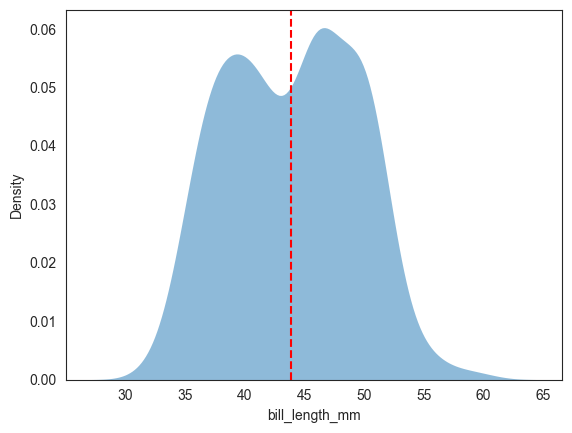

In [16]:
# plotting both distibutions on the same figure
_ = sns.kdeplot(data=penguins, x="bill_length_mm", fill=True, common_norm=False, alpha=.5, linewidth=0, legend=True)
# plot vertical line 
_ = plt.axvline(x=penguins["bill_length_mm"].mean(), color='red', linestyle='--')
# plt.legend()
plt.show();

The kdeplot above is for an univariate, empirical estimation of the whole dataset, not
conditional on any class label.

To see the conditional distribution, we can use the `hue` parameter in `seaborn.kdeplot` to plot the conditional distribution of $X_2$ given $Y=y$. You just imagine that given
say Adelie has happened, then we zoom into the reduced sample space of Adelie, and plot the distribution of $X_2$ in this **reduced sample space**. Things get a bit more complicated when we have more than one predictor, but the idea is the same, we will see later as well.

I want to emphasize that for 1 predictor conditioned on another random variable,
in this case $X_2$ conditioned on $Y$, the conditional distribution is a **marginal distribution**,
or we can view it as **univariate distribution**. This is because once we $Y=y$ has happened,
there is no randomness left in $Y$, we are only looking at the distribution of $X_2$ in the reduced sample space $\mathcal{\Omega}_{X_2|Y}$.

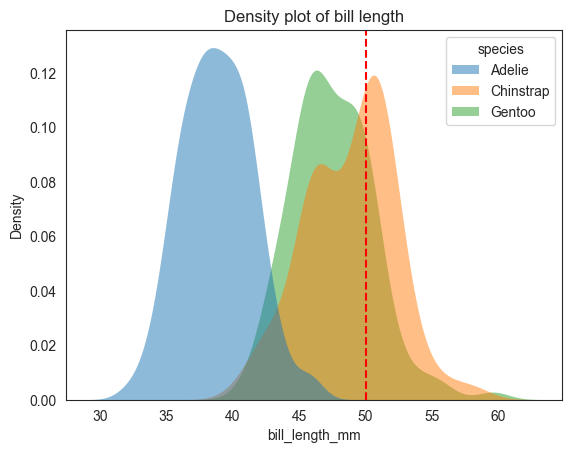

In [17]:
# plotting both distibutions on the same figure
x2 = 50
_ = sns.kdeplot(
    data=penguins,
    x="bill_length_mm",
    hue="species",
    fill=True,
    common_norm=False,
    alpha=0.5,
    linewidth=0,
    legend=True,
)
# plot vertical line
_ = plt.axvline(x2, color="r", linestyle="--", label="50 mm")
plt.title("Density plot of bill length")
# plt.legend()
plt.show();

Before we move on, some EDA on the joint distribution of $X_2$ and $Y$. 
Note very carefully that this is a **joint distribution** of $X_2$ and $Y$, not a **conditional distribution** of $X_2$ given $Y$. 

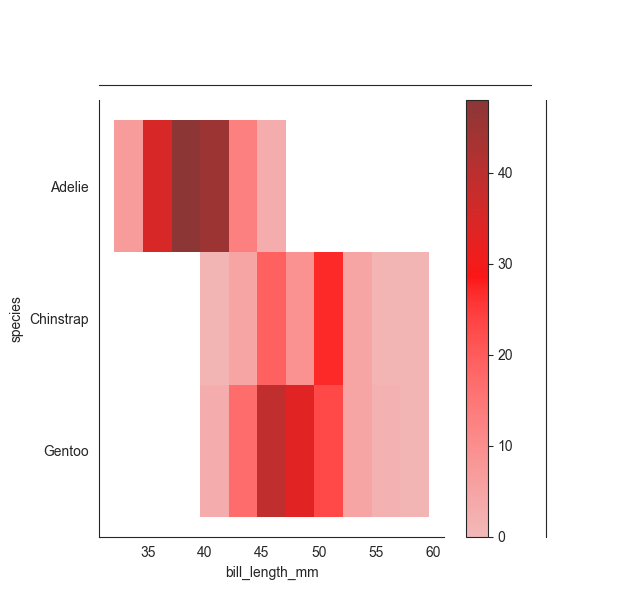

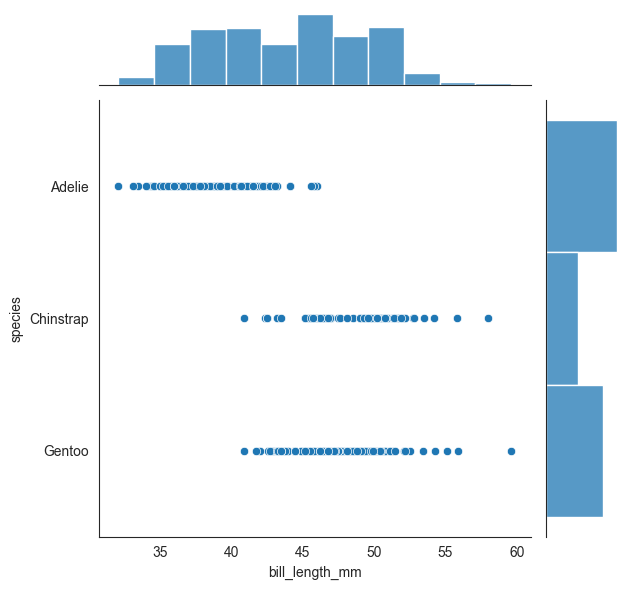

In [18]:
g = sns.JointGrid(data=penguins, x="bill_length_mm", y="species")
g.plot_joint(sns.histplot, color = "red", cbar=True)

sns.jointplot(data=penguins, x="bill_length_mm", y="species")

We see that the for this penguin with `bill_length_mm` of 50mm, our gut feeling tells us
that it most likely is not an Adelie, since the distribution of $X_2$ for Adelie is
much less than 50 mm. It could be a Chinstrap or a Gentoo, but we are not sure which one,
though Chinstrap is tends to be longer for bill length, but the earlier section has 
told us that we should weigh the prior probability of each species into consideration.

We can again use Bayes' rule to compute the posterior probability of $Y=A$ given $X_2=50$,

$$
\begin{aligned}
\mathbb{P}[Y=y|X_2=x_2] = \frac{\mathbb{P}[X_2=x_2|Y=y] \mathbb{P}[Y=y]}{\mathbb{P}[X_2=x_2]}
\end{aligned}
$$

For example, since our given feature is `bill_length_mm` of 50mm, we see

$$ 
\begin{aligned}
\mathbb{P}[Y=A|X_2=50] &= \dfrac{\mathbb{P}[X_2=50|Y=A] \mathbb{P}[Y=A]}{\mathbb{P}[X_2=50]} \\
\mathbb{P}[Y=C|X_2=50] &= \dfrac{\mathbb{P}[X_2=50|Y=C] \mathbb{P}[Y=C]}{\mathbb{P}[X_2=50]} \\
\mathbb{P}[Y=G|X_2=50] &= \dfrac{\mathbb{P}[X_2=50|Y=G] \mathbb{P}[Y=G]}{\mathbb{P}[X_2=50]}
\end{aligned}
$$

Again, we use argmax to solve the problem,

$$
\begin{aligned}
\text{argmax}_{y \in \{A, C, G\}} \mathbb{P}[Y=y|X_2=50] &= \text{argmax}_{y \in \{A, C, G\}} \dfrac{\mathbb{P}[X_2=50|Y=y] \mathbb{P}[Y=y]}{\mathbb{P}[X_2=50]} \\
&= \text{argmax}_{y \in \{A, C, G\}} \dfrac{\mathbb{P}[X_2=50|Y=y] \mathbb{P}[Y=y]}{\sum_{y' \in \{A, C, G\}} \mathbb{P}[X_2=50|Y=y'] \mathbb{P}[Y=y']}
\end{aligned}
$$



Now we met our first hurdle here since $\mathbb{P}[X_2=50|Y=y]$ is not easy to compute since
$X_2$ is a continuous variable, we cannot construct a empirical joint distribution table like
how we did earlier (`species` vs `bill_length_mm` does not work here).

Further, we haven't assumed a model for $X_2$ yet from which to define the likelihood $\mathbb{P}[X_2=50|Y=y]$ or $\mathcal{L}(X_2=50|Y=y)$. We can do like previously to assume **naively (pun intended)** that the distribution of $X_2$ **GIVEN Y** is Gaussian, note carefully
that this is a **conditional distribution** of $X_2$ given $Y$, we can also say in same
term that $X_2$ is **continuous** and **conditionally normal**.

$$
\begin{aligned}
X_2 \mid Y=A \sim \mathcal{N}(\mu_A, \sigma_A^2) \\
X_2 \mid Y=C \sim \mathcal{N}(\mu_C, \sigma_C^2) \\
X_2 \mid Y=G \sim \mathcal{N}(\mu_G, \sigma_G^2)
\end{aligned}
$$

Notice here that it is possible that the three conditional distributions are different with
different $\mu$ and $\sigma$. Technically, we can even assume that the three conditional
distributions come from different families, but we will stick to the Gaussian family for now.
We usually call this the **Gaussian Naive Bayes** model.

Intuitively, we can see that the three species are not well separated in the joint distribution space, so we cannot expect a good performance from the Gaussian Naive Bayes model. For example,
50 mm could well be either Gentoo or Chinstrap. (This understanding may be wrong?) In any case,
in our example, the conditional distribution of $X_2$ given $Y$ appears quite Gaussian.
Even if not so, the Central Limit Theorem tells us that the sum of many independent random
variables tends to be Gaussian, so we can still use the Gaussian Naive Bayes model 
if we have enough data (?).

The next question is how do we estimate the $\mu$ and $\sigma$ for each $X_2$ given $Y$?
We can use the **Maximum Likelihood Estimation** (MLE) method to estimate the parameters (clarify
whether it is MLE of MAP?)

It turns out that the MLE of $\mu$ and $\sigma$ for each $X_2$ given $Y$ is the sample mean
and sample standard deviation of $X_2$ given $Y$. They are unbiased estimators of the true
$\mu$ and $\sigma$! (**FILL In the blanks for the categorical part on Binomial and multinomial**)
See bishops proof also.

The below table summarizes the sample (empirical) mean and sample standard deviation of $X_2$ given $Y$.
For example, the sample mean of $X_2$ given $Y=A$ is 38.8 mm, and the sample standard deviation
is 2.66 mm.

| Species | Sample Mean | Sample Standard Deviation |
|---------|-------------|---------------------------|
| A       | 38.8        | 2.66                      |
| C       | 48.8       | 3.34                     |
| G       | 47.5       | 3.08                     |

Remember again, the sample mean and sample standard deviation are unbiased estimators of the true
$\mu$ and $\sigma$, and can be shown by MLE.

In [19]:
bill_length_mean_std = bill_length_mm.groupby('species').agg(['mean', 'std'])
bill_length_mean_std

bill_length_mm          
                    mean       std
species                           
Adelie         38.791391  2.663405
Chinstrap      48.833824  3.339256
Gentoo         47.504878  3.081857

Let's plot the normal distribution with the sample mean and sample standard deviation for each $X_2$ given $Y$.
We also round off the sample mean and sample standard deviation to 2 decimal places for convenience and
stay true to the original book.

In [20]:
# rv_adelie = stats.norm(bill_length_mean_std.loc['Adelie']['bill_length_mm']['mean'], bill_length_mean_std.loc['Adelie']['bill_length_mm']['std'])
# rv_chinstrap = stats.norm(bill_length_mean_std.loc['Chinstrap']['bill_length_mm']['mean'], bill_length_mean_std.loc['Chinstrap']['bill_length_mm']['std'])
# rv_gentoo = stats.norm(bill_length_mean_std.loc['Gentoo']['bill_length_mm']['mean'], bill_length_mean_std.loc['Gentoo']['bill_length_mm']['std'])

rv_adelie = stats.norm(38.8, 2.66)
rv_chinstrap = stats.norm(48.8, 3.34)
rv_gentoo = stats.norm(47.5, 3.08)

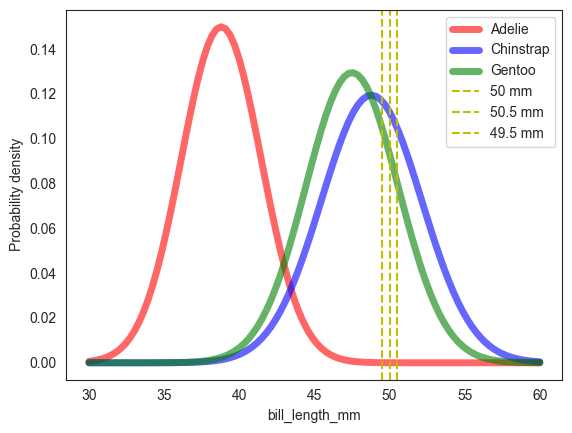

In [21]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.linspace(30, 60, 100), rv_adelie.pdf(np.linspace(30, 60, 100)), 'r-', lw=5, alpha=0.6, label='Adelie')
ax.plot(np.linspace(30, 60, 100), rv_chinstrap.pdf(np.linspace(30, 60, 100)), 'b-', lw=5, alpha=0.6, label='Chinstrap')
ax.plot(np.linspace(30, 60, 100), rv_gentoo.pdf(np.linspace(30, 60, 100)), 'g-', lw=5, alpha=0.6, label='Gentoo')
# plot vertical line
_ = plt.axvline(x2, color="y", linestyle="--", label="50 mm")
_ = plt.axvline(x2+0.5, color="y", linestyle="--", label="50.5 mm")
_ = plt.axvline(x2-0.5, color="y", linestyle="--", label="49.5 mm")
ax.set_xlabel('bill_length_mm')
ax.set_ylabel('Probability density')
ax.legend()
plt.show();

As we can see, the this naive assumption of Gaussian distribution for $X_2$ given $Y$ is not 
perfect, but it isn't too bad either. Note the distinction in the plot here and previously.
The previous diagram is the empirical density plot of the raw data, while this one is the
density plot of the conditional gaussian distribution of $X_2$ given $Y$ where we have
used the sample mean and sample standard deviation as the parameters of the Gaussian $X_2 \mid Y \sim \mathcal{N}(\mu, \sigma^2)$.

Now we can finally solve our "hurdle" problem of computing $\mathbb{P}[X_2=50|Y=y]$.
We can use the Gaussian density function to compute the probability density of $X_2=50$ given $Y=y$.
Geometrically, we can see that the probability density of $X_2=50$ given $Y=y$ is the area under the
curve of the Gaussian density function at $X_2=50$ for each $Y=y$ around a small neighborhood $\delta$
of $X_2=50$. Illustrated in diagram above, the $\delta=0.5$ mm and the area under the curve is
computed by the integral of the Gaussian density function from $X_2=49.5$ to $X_2=50.5$. In reality however,
the $\delta$ is infinitesimally small.

In practice, we just need to compute the probability density of $X_2=50$ given $Y=y$ at $X_2=50$ and
not the actual probability. Note very carefully that PDF is not probability, it is the probability density!!!

So one natural question becomes, as mentioned earlier, we should compute
the posterior conditional PDF and maximize over it instead of the posterior conditional probability
and maximize over it since probability at a point is 0 for continuous variables.

And so our 

$$
\begin{aligned}
f_{X_2 \mid Y}(x_2=50 \mid y=A) &= \frac{1}{\sqrt{2\pi}\sigma_A} \exp \left( -\frac{(x_2 - \mu_A)^2}{2\sigma_A^2} \right) \\
&= \frac{1}{\sqrt{2\pi}\sigma_A} \exp \left( -\frac{(50 - \mu_A)^2}{2\sigma_A^2} \right) \\
&= \frac{1}{\sqrt{38.8} \cdot 2.66} \exp \left( -\frac{(50 - 38.8)^2}{2 \cdot 2.66^2} \right) \\
&= 0.0000212 
\end{aligned}
$$

Similarly,

$$
\begin{aligned}
f_{X_2 \mid Y}(x_2=50 \mid y=C) &= 0.112 \\
f_{X_2 \mid Y}(x_2=50 \mid y=G) &= 0.09317 \\
\end{aligned}
$$

Note that $\mu_A$ and $\sigma_A$ are the sample mean and sample standard deviation of $X_2$ given $Y=A$.
Notation wise it is fine but you can also view it as $\mu_{A|X_2}$ and $\sigma_{A|X_2}$.

READ HERE, DON'T BE LAZY:

- https://www.probabilitycourse.com/chapter5/5_2_3_conditioning_independence.php
- https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/maximum-likelihood.html#summary
- Chan's book.
- Write out into content for my notes!!!

In [22]:
px2_given_adelie = rv_adelie.pdf(x2)
px2_given_chinstrap = rv_chinstrap.pdf(x2)
px2_given_gentoo = rv_gentoo.pdf(x2)

print(f'P(X_2=50|Adelie) = {px2_given_adelie:.7f}')
print(f'P(X_2=50|Chinstrap) = {px2_given_chinstrap:.3f}')
print(f'P(X_2=50|Gentoo) = {px2_given_gentoo:.5f}')

P(X_2=50|Adelie) = 0.0000212
P(X_2=50|Chinstrap) = 0.112
P(X_2=50|Gentoo) = 0.09317


As an example, the probability density of $X_2=50$ given $Y=A$ is $0.0000212 \text{ mm}^{-1}$, and indeed from
the plot above, the area under the curve is definitely the smallest, and the lowest since there is 
almost no Adelie with 50 mm bill length.

So the marginal PDF of observing a penguin with a 50 mm bill length is,

$$
\begin{aligned}
f_{X_2}(50) &= \sum_{y \in \mathcal{Y}} f_{X_2|Y}(50|y) f_{Y}(y) \\
&= \frac{151}{342} \cdot 0.0000212 + \frac{68}{342} \cdot 0.112 + \frac{123}{342} \cdot 0.09317 \\
&= 0.05579
\end{aligned}
$$

Once again, this number is not a probability, it is the probability density, it just means for 
every 1 mm, there is a 0.05579 mm chance of observing a penguin with a 50 mm bill length AROUND THAT SMALL NEIGHBORHOOD.
In laymen, it is how "dense" the probability is at that point. 

Then, the posterior conditional PDF of $Y$ given $X_2=50$ is,

$$
\begin{aligned}
f_{Y|X_2}(y=A|x_2=50) &= \frac{f_{X_2|Y}(x_2=50|y=A) f_{Y}(y=A)}{f_{X_2}(x_2=50)} \\
&= \dfrac{(151/342) \cdot 0.0000212}{0.05579} \\
&\approx 0.0002
\end{aligned}
$$


$$
\begin{aligned}
f_{Y|X_2}(y=C|x_2=50) \approx 0.3992 \\
\end{aligned}
$$

$$
\begin{aligned}
f_{Y|X_2}(y=G|x_2=50) \approx 0.6006 \\
\end{aligned}
$$

Again note that these are not probabilities, they are probability densities. This time round,
the final results was pushed over again by the fact that Gentoo is more common in the wild (prior $P(Y=G)\approx 0.3605$).

### Two Predictors

The reality is that the data is usually multi-dimensional, and we need to use multiple predictors
to make a prediction.

In the previous two examples, we have seen that for the same penguin with the following features,

- `body_mass_g` $< 4200 \mathrm{~g}$ (`overweight` = 0 if `body_mass_g` $< 4200 \mathrm{~g}$, 1 otherwise)
- `bill_length_mm` $50 \mathrm{~mm}$
- `flipper_length_mm` $195 \mathrm{~mm}$

the predictions for the species is an Adelie if we only use `overweight`, and
a Gentoo if we only use `bill_length_mm`. This inconsistency suggest that
our model may have room for improvement. Intuitively, we can add
multiple predictors to our model to make a more accurate prediction, though
this is not always the case if the predictors are correlated, or if there are
too many predictors (curse of dimensionality).

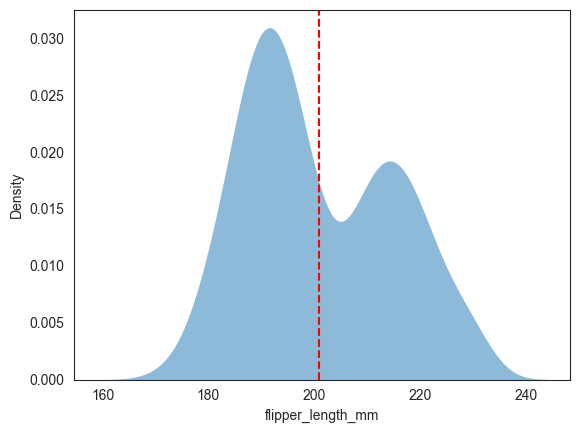

In [23]:
# plotting both distibutions on the same figure
_ = sns.kdeplot(data=penguins, x="flipper_length_mm", fill=True, common_norm=False, alpha=.5, linewidth=0, legend=True)
# plot vertical line 
_ = plt.axvline(x=penguins["flipper_length_mm"].mean(), color='red', linestyle='--')
# plt.legend()
plt.show();

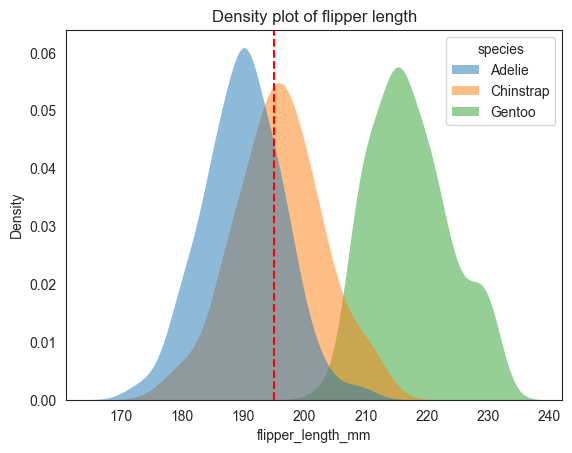

In [24]:
# plotting both distibutions on the same figure
x3 = 195
_ = sns.kdeplot(
    data=penguins,
    x="flipper_length_mm",
    hue="species",
    fill=True,
    common_norm=False,
    alpha=0.5,
    linewidth=0,
    legend=True,
)
# plot vertical line
_ = plt.axvline(x3, color="r", linestyle="--", label="195 mm")
plt.title("Density plot of flipper length")
# plt.legend()
plt.show();

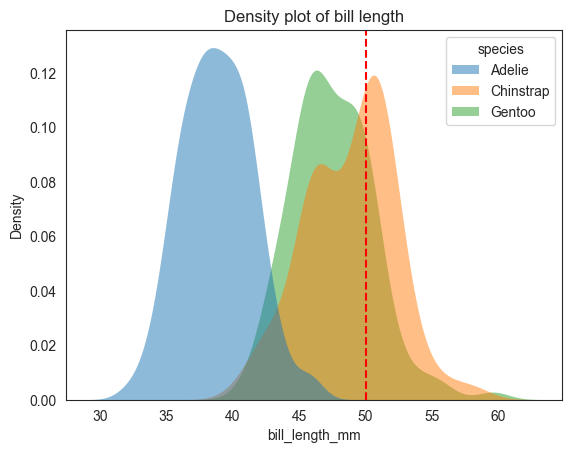

In [25]:
# plotting both distibutions on the same figure
x2 = 50
_ = sns.kdeplot(
    data=penguins,
    x="bill_length_mm",
    hue="species",
    fill=True,
    common_norm=False,
    alpha=0.5,
    linewidth=0,
    legend=True,
)
# plot vertical line
_ = plt.axvline(x2, color="r", linestyle="--", label="50 mm")
plt.title("Density plot of bill length")
# plt.legend()
plt.show();

The `bill_length_mm` and `flipper_length_mm` are plotted above as density plots,
just by looking at them alone may be hard to distinguish between the
Chinstrap and Gentoo for the `bill_length_mm` plot because they are
quite close (overlap in density curve) with each other, while if you
only look at the `flipper_length_mm` plot, you can see that the Chinstrap and 
Adelie are now quite close to each other, but if you combine
both `bill_length_mm` and `flipper_length_mm` together, you can see that
it is much easier to distinguish between them.


#### Plots!!!

This plot is from [Seaborn guide](https://seaborn.pydata.org/tutorial/distributions.html#distribution-visualization-in-other-settings), one can see with default setting
we have a joint plot of `bill_length_mm` and `flipper_length_mm` with the marginal
histograms on the side. The joint plot is a scatter plot of the two variables.

The plot with `kind=hist` will show the joint distribution as a histogram, and the
rectangular bins are colored by the density of the points in each bin. The darker
the color the more points in that bin. You can understand this as impulses from chan's book.

Lastly, the plot with `kind=kde` will show the joint distribution as a contour plot.

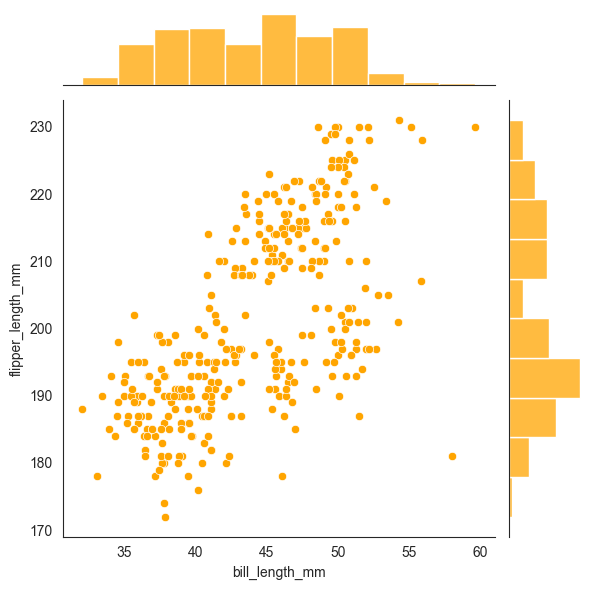

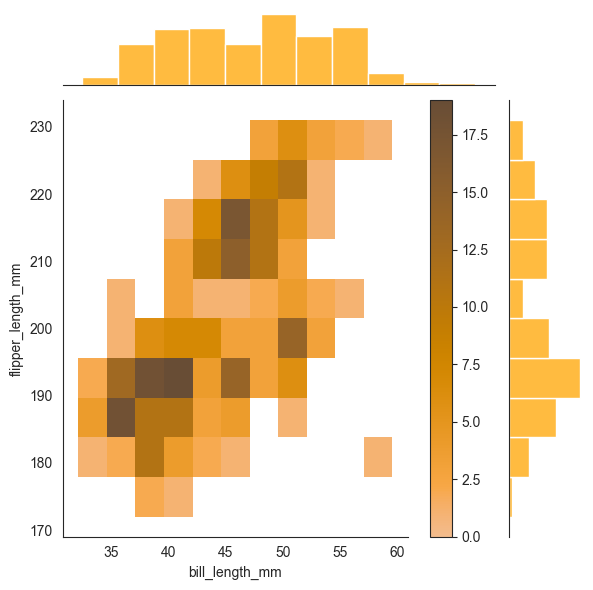

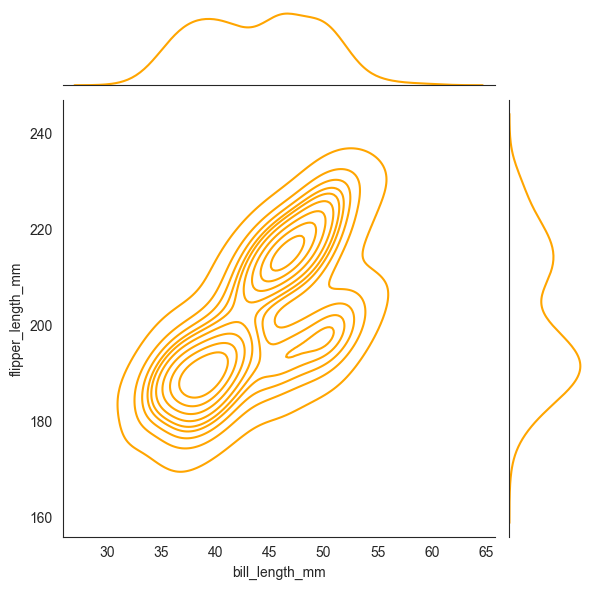

In [26]:
sns.jointplot(data=penguins, x="bill_length_mm", y="flipper_length_mm", color="orange")
sns.jointplot(
    data=penguins,
    x="bill_length_mm",
    y="flipper_length_mm",
    kind="hist",
    color="orange",
    cbar=True,
)
sns.jointplot(
    data=penguins,
    x="bill_length_mm",
    y="flipper_length_mm",
    kind="kde",
    color="orange",
    # cbar=True,
)

To see the joint distribution conditioned on the class (species) $Y$, where $Y$
can be treated as a random variable as well [^1], we can use the `hue` argument.

To emphasise, the way to approach conditional distributions is to zoom in on the
"reduced" sample space, for example if I want to look at the conditional distribution
of $X_2$ and $X_3$ conditioned on $Y=G$, then you should look at the green colored
hues.

[^1]: In Naive Bayes, both the predictor and the target are random variables, while
it is not the case for logistic regression. Regardless, once you condition on $Y$, $Y$
is no longer random.

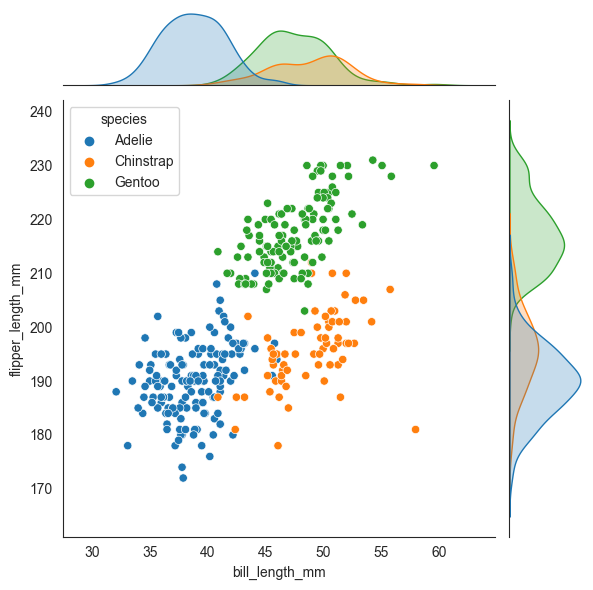

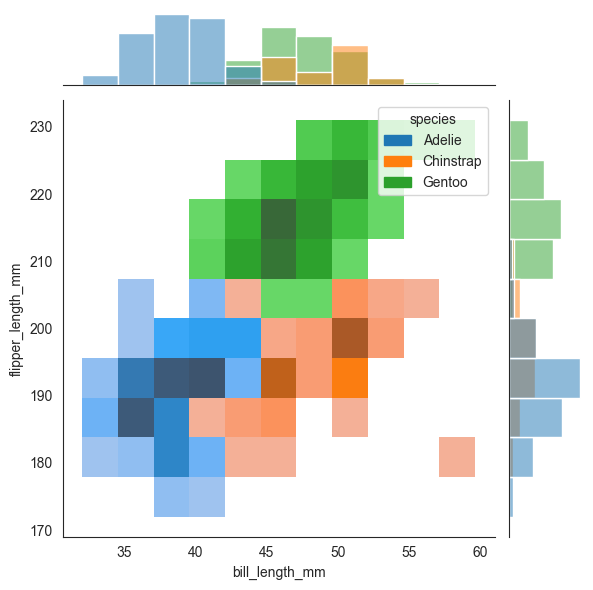

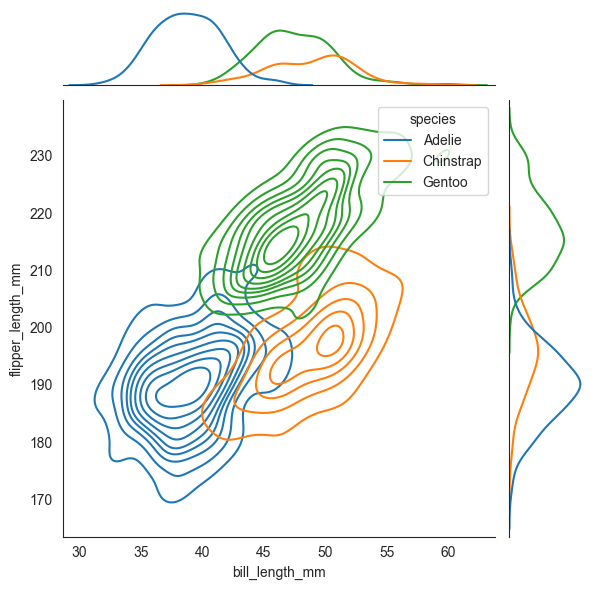

In [27]:
sns.jointplot(data=penguins, x="bill_length_mm", y="flipper_length_mm", hue="species")
sns.jointplot(
    data=penguins, x="bill_length_mm", y="flipper_length_mm", hue="species", kind="hist"
)
sns.jointplot(
    data=penguins, x="bill_length_mm", y="flipper_length_mm", hue="species", kind="kde"
)


Now we plot two dashed lines for where $X_2=50$ and $X_3=195$ respectively, and
see that when combined together, the penguin lies amongst the Chinstrap species, 
and it is not even close to the other two speces!!

To internalize this concept, we are again looking at the argmax expression below:

$$
\begin{aligned}
\hat{y} &= \arg\max_{y \in \mathcal{Y}} \mathbb{P}(Y=y|X_2=x_2,X_3=x_3) \\
        &= \arg\max_{y \in \mathcal{Y}} \mathbb{P}(Y=y|X_2=50,X_3=195) \\
\end{aligned}
$$

or equivalently,

$$
\begin{aligned}
\hat{y} &= \arg\max_{y \in \mathcal{Y}} f_{Y|X_2,X_3}(y|x_2,x_3) \\
        &= \arg\max_{y \in \mathcal{Y}} f_{Y|X_2,X_3}(y|50,195) \\
\end{aligned}
$$

We want to know **given each species $Y$**, which $y$ **maximizes**
this conditional probability density function $f_{Y|X_2,X_3}(y|x_2,x_3)$.
In other words, given $X_2=50$ and $X_3=195$, which species $Y$ has the highest
"probability" of being the true species of the penguin. And from the diagram,
we can see that the Chinstrap species has the highest probability of being the true
species of the penguin. We will see later that the geometric interpretation of this
is correct, with the formula.


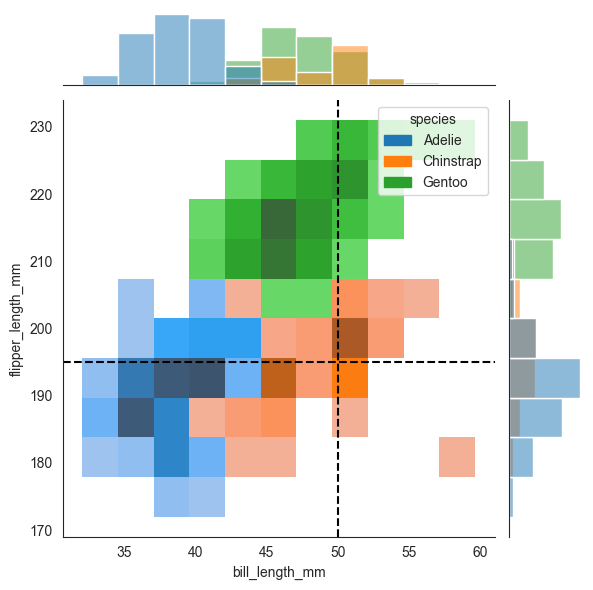

In [28]:
# sns.jointplot(data=penguins, x="bill_length_mm", y="flipper_length_mm", hue="species")
sns.jointplot(
    data=penguins, x="bill_length_mm", y="flipper_length_mm", hue="species", kind="hist"
)

_ = plt.axvline(x2, color="black", linestyle="--", label="50 mm")
_ = plt.axhline(x3, color="black", linestyle="--", label="195 mm")

#### Conditional Independence

Let's use naive Bayes to make a prediction for the same penguin with the following features
$X_2=x_2$ and $X_3=x_3$.

$$
\begin{aligned}
f_{Y|X_2,X_3}(y|x_2,x_3) &= \frac{f_{X_2,X_3|Y}(x_2,x_3|y) f_{Y}(y)}{f_{X_2,X_3}(x_2,x_3)} \\
                         &= \frac{f_{X_2,X_3|Y}(x_2,x_3|y) f_{Y}(y)}{\sum_{y \in \mathcal{Y}} f_{X_2,X_3|Y}(x_2,x_3|y) f_{Y}(y)} \\
\end{aligned}
$$

Another hurdle is presented in front of us, we need to compute the conditional
joint distribution (PDF) $f_{X_2,X_3|Y}(x_2,x_3|y)$, which is not easy to do...in fact
I have no idea how to do it. This is because we were dealing with only one-dimensional
distribution, even though there are two variables just now, but as I mentioned,
when we condition on $Y$, we are looking at the reduced sample space of $X$ in 
which $Y$ is fixed,
and not the joint sample space of $X$ and $Y$. This is the reason why we can happily
use 1dimensional Gaussian to get the conditional distribution of $X_2$.

To reconcile this, Naive Bayes assumes that the predictors are **conditionally independent**[^1].
It states that given a set of continuous predictors $X_1, \ldots, X_n$, they are called conditionally
independent given $Y$ if the joint distribution of $X_1, \ldots, X_n$ given $Y$ can be written as

$$
f_{X_1,\ldots,X_n|Y}(x_1,\ldots,x_n|y) = \prod_{i=1}^n f_{X_i|Y}(x_i|y)
$$

The theorem holds for discrete case as well with the difference being that the
PDF is replaced by the PMF.

This theorem means that ***within each class (species)***, the predictors are independent.
More concretely, if we say that $X_2$ and $X_3$ are conditionally independent given $Y$,
then we are saying that ***within each class (species)***, the `bill_length_mm` ($X_2$)
is independent of the `flipper_length_mm` ($X_3$). This is a very strong assumption,
but is at the heart of Naive Bayes and many other algorithms. It simplifies the parameters a lot 
(see d2l on the parameters reduction). Such a strong assumption is usually not always true, 
see the plot below again, within the class `Gentoo`, we can see that the `bill_length_mm`
and `flipper_length_mm` exhibit some positive correlation. We will still use this assumption
even though it is not perfect.

[^1]: https://statproofbook.github.io/D/ind-cond

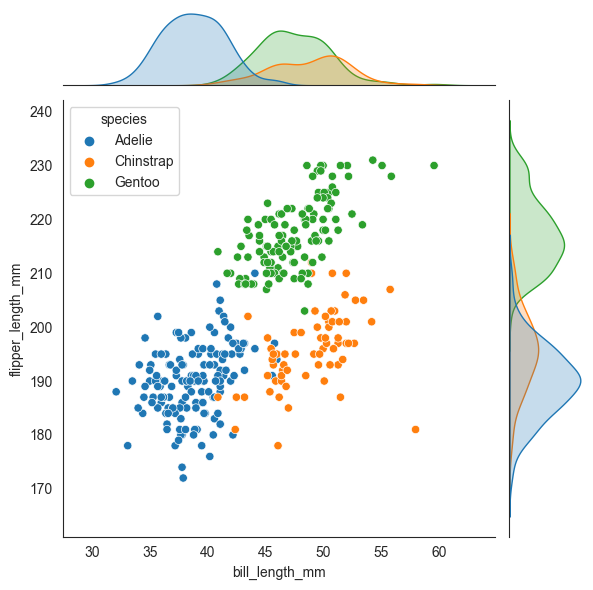

In [29]:
sns.jointplot(data=penguins, x="bill_length_mm", y="flipper_length_mm", hue="species")

Back to our 

$$
\begin{aligned}
f_{Y|X_2,X_3}(y|x_2,x_3) &= \frac{f_{X_2,X_3|Y}(x_2,x_3|y) f_{Y}(y)}{f_{X_2,X_3}(x_2,x_3)} \\
                         &= \frac{f_{X_2,X_3|Y}(x_2,x_3|y) f_{Y}(y)}{\sum_{y \in \mathcal{Y}} f_{X_2,X_3|Y}(x_2,x_3|y) f_{Y}(y)} \\
\end{aligned}
$$

We now have an answer on how to unpack the joint conditional distribution $f_{X_2,X_3|Y}(x_2,x_3|y)$.

We can merely do

$$
\begin{aligned}
f_{X_2,X_3|Y}(x_2,x_3|y) &= f_{X_2|Y}(x_2|y) f_{X_3|Y}(x_3|y) \\
\end{aligned}
$$

so that our previous expression becomes

$$
\begin{aligned}
f_{Y|X_2,X_3}(y|x_2,x_3) &= \frac{f_{X_2|Y}(x_2|y) f_{X_3|Y}(x_3|y) f_{Y}(y)}{\sum_{y \in \mathcal{Y}} f_{X_2|Y}(x_2|y) f_{X_3|Y}(x_3|y) f_{Y}(y)} \\
\end{aligned}
$$

In [30]:
flipper_length_mean_std = penguins.groupby("species")["flipper_length_mm"].agg(["mean", "std"]) 
flipper_length_mean_std

,mean,std
species,,
Adelie,189.953642,6.539457
Chinstrap,195.823529,7.131894
Gentoo,217.186992,6.484976


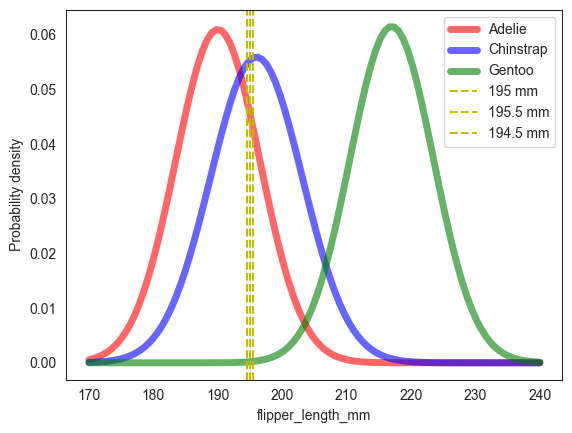

In [31]:
rv_adelie = stats.norm(190., 6.54)
rv_chinstrap = stats.norm(196., 7.13)
rv_gentoo = stats.norm(217., 6.48)

fig, ax = plt.subplots(1, 1)
ax.plot(np.linspace(170, 240, 100), rv_adelie.pdf(np.linspace(170, 240, 100)), 'r-', lw=5, alpha=0.6, label='Adelie')
ax.plot(np.linspace(170, 240, 100), rv_chinstrap.pdf(np.linspace(170, 240, 100)), 'b-', lw=5, alpha=0.6, label='Chinstrap')
ax.plot(np.linspace(170, 240, 100), rv_gentoo.pdf(np.linspace(170, 240, 100)), 'g-', lw=5, alpha=0.6, label='Gentoo')
# plot vertical line
_ = plt.axvline(x3, color="y", linestyle="--", label="195 mm")
_ = plt.axvline(x3+0.5, color="y", linestyle="--", label="195.5 mm")
_ = plt.axvline(x3-0.5, color="y", linestyle="--", label="194.5 mm")
ax.set_xlabel('flipper_length_mm')
ax.set_ylabel('Probability density')
ax.legend()
plt.show();

In [32]:
px3_given_adelie = rv_adelie.pdf(x3)
px3_given_chinstrap = rv_chinstrap.pdf(x3)
px3_given_gentoo = rv_gentoo.pdf(x3)

print(f'P(X_3=195|Adelie) = {px3_given_adelie:.5f}')
print(f'P(X_3=195|Chinstrap) = {px3_given_chinstrap:.5f}')
print(f'P(X_3=195|Gentoo) = {px3_given_gentoo:.7f}')

P(X_3=195|Adelie) = 0.04554
P(X_3=195|Chinstrap) = 0.05541
P(X_3=195|Gentoo) = 0.0001934


For formality, the code above translates to 

$$
\begin{aligned}
f_{X_3|Y}(x_3=195|y=A) &= \frac{1}{\sqrt{2\pi}\sigma_{A}} \exp\left(-\frac{(195-\mu_{A})^2}{2\sigma_A^2}\right) \\
&= 0.04554
\end{aligned}
$$

Similarly, we can compute the other two conditional distributions to be $0.05541$ and $0.0001934$ respectively.

Next, we compute the denominator, which is the joint distribution of observing $X_2=50$ and $X_3=195$.

$$
\begin{aligned}
\sum_{y \in \mathcal{Y}} f_{X_2|Y}(x_2|y) f_{X_3|Y}(x_3|y) f_{Y}(y) &= \sum_{y \in \mathcal{Y}} f_{X_2|Y}(x_2=50|y) f_{X_3|Y}(x_3=195|y) f_{Y}(y) \\
&= f_{X_2|Y=A}(x_2=50|y=A) f_{X_3|Y=A}(x_3=195|y=A) f_{Y}(y=A) \\
&+ f_{X_2|Y=C}(x_2=50|y=C) f_{X_3|Y=C}(x_3=195|y=C) f_{Y}(y=C) \\
&+ f_{X_2|Y=G}(x_2=50|y=G) f_{X_3|Y=G}(x_3=195|y=G) f_{Y}(y=G) \\
&= 0.0000212 \cdot 0.04554 \cdot \frac{151}{342} \\
&+ 0.112 \cdot 0.05541 \cdot \frac{68}{342} \\
&+ 0.09317 \cdot 0.0001934 \cdot \frac{123}{342} \\
&\approx 0.001241
\end{aligned}
$$


We plug into Bayes' rule to get the posterior probability of $Y=A$ given $X_2=50$ and $X_3=195$.

$$
\begin{aligned}
f_{Y=A|X_2,X_3}(y=A|x_2=50,x_3=195) &= \frac{f_{X_2|Y=A}(x_2=50|y=A) f_{X_3|Y=A}(x_3=195|y=A) f_{Y}(y=A)}{\sum_{y \in \mathcal{Y}} f_{X_2|Y}(x_2|y) f_{X_3|Y}(x_3|y) f_{Y}(y)} \\
&= \frac{0.0000212 \cdot 0.04554 \cdot \frac{151}{342}}{0.001241} \\
&\approx 0.0003
\end{aligned}
$$

Similarly, we can compute the posterior probability of $Y=C$ and $Y=G$ given $X_2=50$ and $X_3=195$.

$$
\begin{aligned}
f_{Y=C|X_2,X_3}(y=C|x_2=50,x_3=195) &\approx 0.9944 \\
f_{Y=G|X_2,X_3}(y=G|x_2=50,x_3=195) &\approx 0.0052
\end{aligned}
$$

We then take the argmax of the posterior probabilities to get the prediction. In this case,
it is $Y=C$ with a posterior probability of $0.9944$. To be pedantic, be reminded that this value is
not a probability but a 

### Three Predictors

Even though not mentioned in the book, we can also use 3 predictors to make a prediction.
The three predictors are `overweight`, `bill_length_mm`, and `flipper_length_mm`. The tricky
part is that `overweight` is a categorical variable, and `bill_length_mm` and `flipper_length_mm`
are continuous variables. We can still do it though, [dafriedman97](https://dafriedman97.github.io/mlbook/content/c4/concept.html#model-structure)
mentioned that we for a random vector $\mathrm{X_n} = (X_{n1}, X_{n2}, \ldots, X_{nd})$, the individual
predictors can take on different distributions. In our case, `overweight` is assumed to be follow a Bernoulli distribution,
`bill_length_mm` and `flipper_length_mm` are assumed to be follow a Gaussian distribution. Note again that
this is an assumption, and we can always change it to something else if we want to since Naive Bayes does
not have any assumptions on the distribution of the predictors (potentially confusing part!).

16/12/2022

once i get prob of 0.3992 , 0.6006 and 0.0002, we can then reconcile with the
conditional KDE plot above, and "eyeball" that for 50mm, the area under the
curve for a small neighbourhood $\delta$ is indeed higher for Gentoo than
Chinstrap. Is this decision boundary? No I doubt so, clarify?

- prior is low but likelihood is high, so posterior may not be high if prior << likelihood
- Normalizing constant. argmax so it does not matter if output is probability? because for an image vector input of a certain x = [1,2,3] for eg, the P(Y=k|x) for Y = 0, 1, 2,...9 for that image are fixed at the given x, and as a result we need to compare the p(y|x) for diff y and see which is highest value. MOreover, it says that in D2L the sum of p(y|x) over y is 1, so we can cross multiply anwyays to get?
    - Furthermore, $P(X_i=x_i)$ is constant during argmax comparison, see 14.1.1 and 14.1.2 in bayes rules book, denominator is rules of total probability, so it is constant.
- Key is estimating , like P(y) we dk population! but estimate from samples, so MLE tells us that indeed 
the best estimate is derived from the sample mean. Same for the mean of the conditional distribution.

conditionally normal means within each class, the data is normal. reasonable assumption because of central limit theorem.

- Plotting the tuned Normal models for each species confirms that this naive Bayes assumption isn’t perfect – it’s a bit more idealistic than the density plots of the raw data in Figure 14.2. But it’s fine enough to continue. THIS IS BECAUSE THE ORIGINAL DATA IS NOT EXACTLY NORMAL, BUT THE CONDITIONAL NORMAL ASSUMPTION IS GOOD ENOUGH TO CONTINUE.
- Note only assumption of Naive Bayes is the random variables within xn are independent conditional on the class of observation.

- The plot below is the 1-d empirical distribution of `bill_length_mm` for all species.
- The vertical red line is the mean of the empirical distribution.
- This is where one “naive” part of naive Bayes classification comes into play. The naive Bayes method typically assumes that any quantitative predictor, here `X_2 = bill_length_mm`
    is continuous and conditionally Normal.

**Important**

From sklearn: and we can use Maximum A Posteriori (MAP) estimation to estimate $P(y)$  and $P(x_i|y)$ ; the former is then the relative frequency of class y in the training set.

The different naive Bayes classifiers differ mainly by the assumptions they make regarding the distribution of $P(x_i|y)$.

page 475 of chans book says that sample mean of the normal distribution coincides when you use MLE to estimate the mean parameter of the normal distribution.
In other words, if $X_2 | Y = A \sim N(\mu_{A}, \sigma_{A}^2)$, then to find the $P(X_2 | Y = A)$, which is the probability of $X_2=x_2$ given $Y=A$,
we know that conditional PDF is about $X_2$ as $Y$ is fixed, so we need the parameters $\mu_{A}$ and $\sigma_{A}^2$ to find the PDF.  

So this is an inverse problem of finding the parameters $\mu_{A}$ and $\sigma_{A}^2$. 
A bit confused see chans page 469, but overall, the idea is that we want to find the parameters of the normal distribution that best fit the data.
And we use MLE to find the parameters of the normal distribution that best fit the data. It turns the parameters
found through MLE are the sample mean and sample variance of the data.

Penguin with bill length of 50mm.


$P(x_2=50|y=Adelie)$

In [33]:
# plot conditional distribution of bill length given species



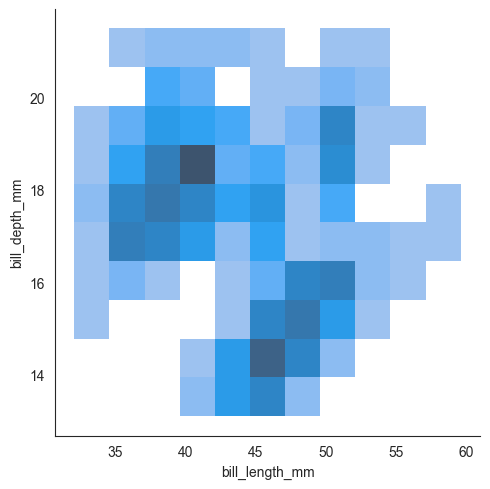

In [34]:
sns.displot(penguins, x="bill_length_mm", y="bill_depth_mm")

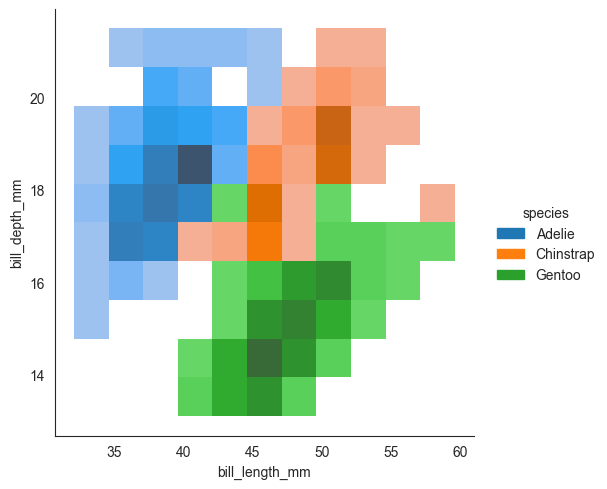

In [35]:
sns.displot(penguins, x="bill_length_mm", y="bill_depth_mm", hue="species")

## References

- https://en.wikipedia.org/wiki/Categorical_distribution
- https://en.wikipedia.org/wiki/Lagrange_multiplier